solubility_az.csv: 0 duplicate SMILES
solubility_biogen.csv: 0 duplicate SMILES
SOMAS_25_OChem.csv: 0 duplicate SMILES
SOMAS_25_Frontiers in Oncology 2020; 10.doi.10.3389_fonc.20.csv: 0 duplicate SMILES
AqSolDB_B.csv: 0 duplicate SMILES
AqSolDB_C.csv: 0 duplicate SMILES
AqSolDB_A.csv: 0 duplicate SMILES


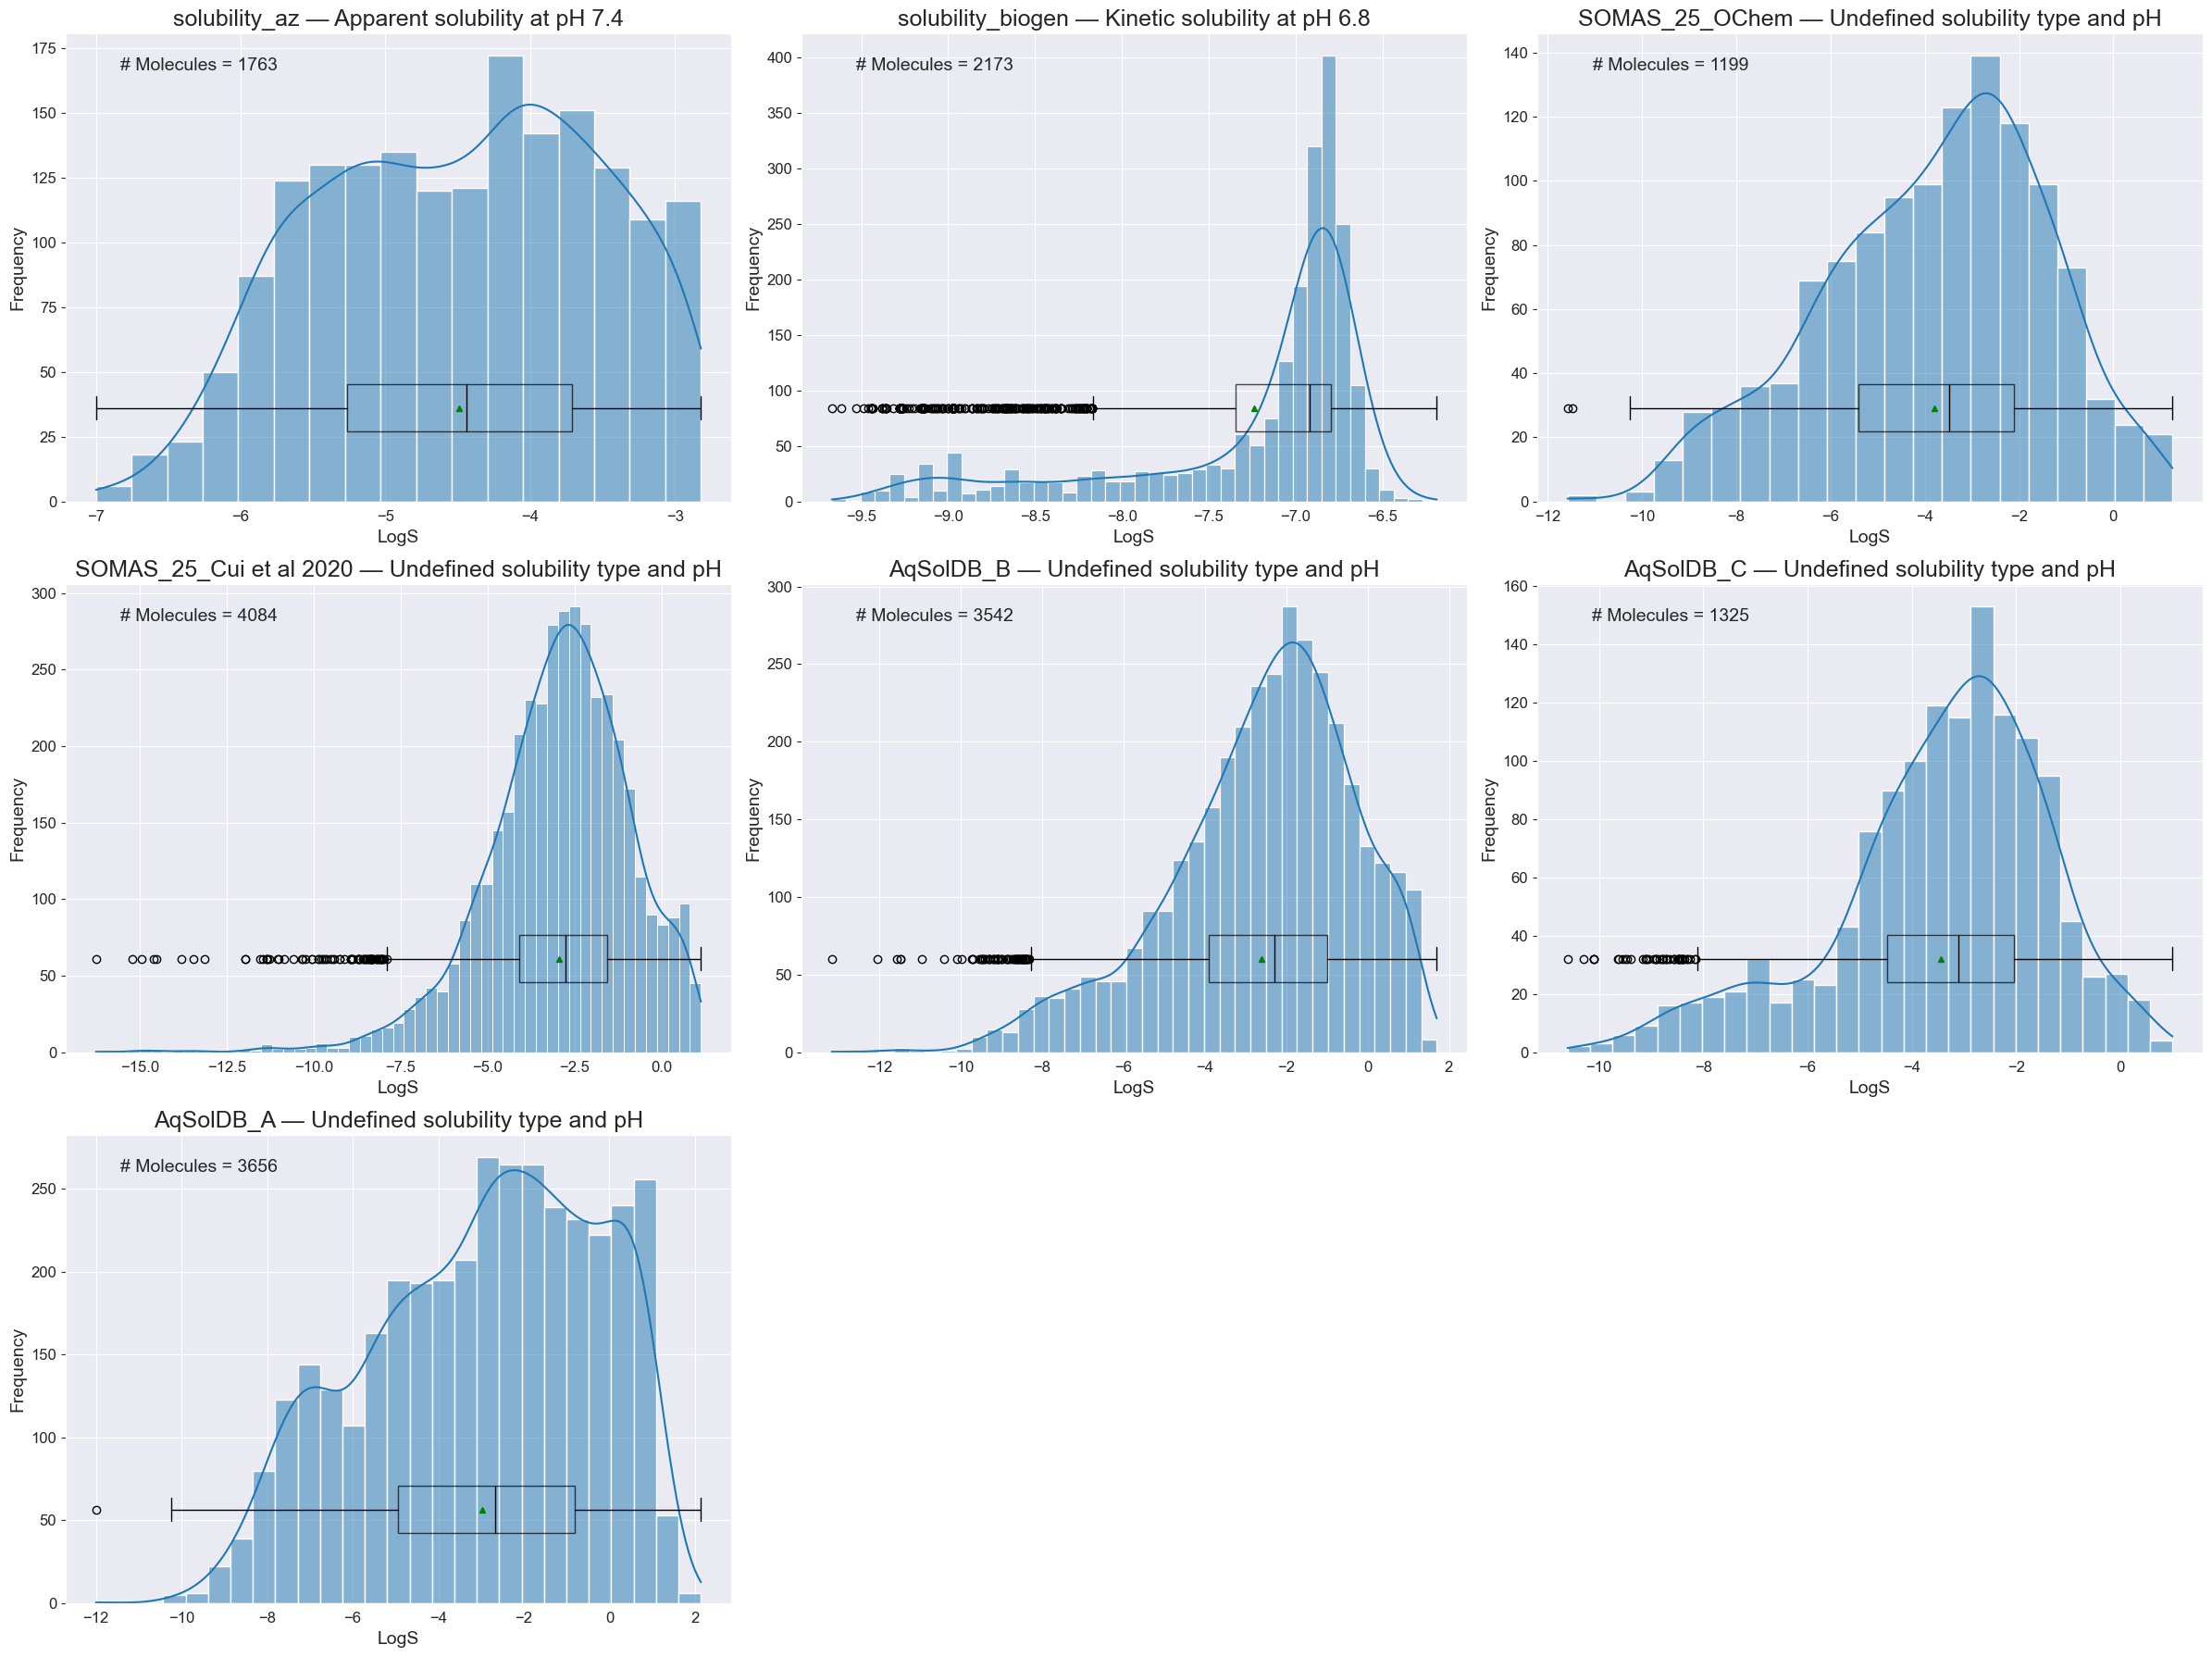

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path


def _annotate_text(ax, text, loc=(0.5, 0.95), fontsize=10):
    ax.text(loc[0], loc[1], text,
            transform=ax.transAxes,
            fontsize=fontsize,
            ha='center',
            va='top')


def plot_feature_distribution(series: pd.Series,
                              ax: plt.Axes,
                              x_label: str = '',
                              annotate_count: bool = True,
                              is_discrete: bool = False):
    ds_values = series.dropna()
    bin_edges = np.histogram_bin_edges(ds_values, bins='auto')
    sns.histplot(ds_values, bins=bin_edges, kde=not is_discrete, ax=ax)

    if not is_discrete:
        ax_box = ax.twinx()
        ax_box.set_ylim(0, 1)
        ax_box.set_xlim(ax.get_xlim())
        y_pos = 0.2
        ax_box.boxplot(ds_values,
                       vert=False,
                       positions=[y_pos],
                       widths=0.1,
                       patch_artist=True,
                       boxprops=dict(facecolor='none', alpha=0.7),
                       medianprops=dict(color='black', linewidth=1))
        ax_box.plot(np.mean(ds_values), y_pos, '^', color='green', ms=5)
        ax_box.set(yticks=[], ylabel='')

    if annotate_count:
        sample_count = len(ds_values)
        _annotate_text(ax,
                       text=f"# Molecules = {sample_count}",
                       fontsize=14,
                       loc=(0.2, 0.95))

    ax.set_xlabel(x_label, fontsize=14)
    ax.set_ylabel('Frequency', fontsize=14)
    ax.set_title(series.name, fontsize=18)
    # Increase tick label font sizes
    ax.tick_params(axis='both', labelsize=12)


# ---------- Analyze all 'by_source' datasets ----------
input_dir = Path("aqueous_solubility/by_source")
def get_priority(file: Path) -> int:
    fname = file.name.lower()
    if 'az' in fname:
        return 0
    elif 'biogen' in fname:
        return 1
    else:
        return 2

csv_files = sorted(input_dir.glob("*.csv"), key=get_priority)

n_files = len(csv_files)
ncols = 3
nrows = int(np.ceil(n_files / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 8, nrows * 6))
axes = axes.flatten()

for i, file in enumerate(csv_files):
    df = pd.read_csv(file)

    # Check for duplicates
    duplicate_count = df.duplicated(subset='SMILES').sum()
    print(f"{file.name}: {duplicate_count} duplicate SMILES")

    # Define plot title logic
    fname = file.name.lower()
    if 'az' in fname:
        title = f"{file.stem} — Apparent solubility at pH 7.4"
    elif 'biogen' in fname:
        title = f"{file.stem} — Kinetic solubility at pH 6.8"
    else:
        stem = file.stem
        if "Frontiers in Oncology 2020" in stem:
            stem = stem.replace("Frontiers in Oncology 2020; 10.doi.10.3389_fonc.20", "Cui et al 2020")
        title = f"{stem} — Undefined solubility type and pH"

    # Assign name for title and plot
    df['LogS'].name = title
    plot_feature_distribution(df['LogS'], ax=axes[i], x_label="LogS")

# Remove unused subplots if any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

#fig.suptitle("Solubility Distributions by Dataset Source", fontsize=14, y=1.02)
plt.tight_layout()

plt.savefig("../../images/evaluation_1/sol_datasets.png")

plt.show()
